In [1]:
# Load our Pkgs
from pyspark import SparkContext

In [2]:
sc = SparkContext(master='local[2]')

22/11/24 13:45:04 WARN Utils: Your hostname, Srijanas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.20 instead (on interface en0)
22/11/24 13:45:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/24 13:45:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [4]:
# Load Pkgs 
from pyspark.sql import SparkSession

In [5]:
# Spark
spark = SparkSession.builder.appName("EmotionClassifierwithSpark").getOrCreate()

In [6]:
# Load our dataset
df = spark.read.csv("data/emotion_dataset_raw.csv",header=True,inferSchema=True)


In [7]:
df.show()

+--------+--------------------+
| Emotion|                Text|
+--------+--------------------+
| neutral|              Why ? |
|     joy|Sage Act upgrade ...|
| sadness|ON THE WAY TO MY ...|
|     joy| Such an eye ! Th...|
|     joy|@Iluvmiasantos ug...|
|    fear|I'm expecting an ...|
| sadness| .Couldnt wait to...|
|surprise|maken Tip 2: Stop...|
|surprise|En dan krijg je f...|
|surprise| @1116am Drummer ...|
|   anger|"The bull tossed ...|
| sadness|People hide their...|
|     joy|For once in his l...|
|    fear|Against the assau...|
|   anger| With everything ...|
| sadness|Shakuhachi dress ...|
|surprise|Haha of course I ...|
|     joy|I have a feeling ...|
|     joy| Good.Let ' s go ...|
|surprise|@JuliaLeader I re...|
+--------+--------------------+
only showing top 20 rows



In [8]:
# check for columns
print(df.columns)

['Emotion', 'Text']


In [9]:
# Check for datatypes
# Before InferSchema=True
df.dtypes

[('Emotion', 'string'), ('Text', 'string')]

In [10]:
# Check for the Schema
df.printSchema()

root
 |-- Emotion: string (nullable = true)
 |-- Text: string (nullable = true)



In [11]:
# Descriptive summary
print(df.describe().show())

+-------+--------+--------------------+
|summary| Emotion|                Text|
+-------+--------+--------------------+
|  count|   34792|               34792|
|   mean|    null|                12.0|
| stddev|    null|                null|
|    min|   anger|     !!!1!  Merry...|
|    max|surprise| RT “@jamiedorsc...|
+-------+--------+--------------------+

None


In [13]:
# Value Count 
df.groupBy('Emotion').count().show()

+--------+-----+
| Emotion|count|
+--------+-----+
|   shame|  146|
|     joy|11045|
| neutral| 2254|
|   anger| 4297|
|    fear| 5410|
|surprise| 4062|
| sadness| 6722|
| disgust|  856|
+--------+-----+



## Feature Engineering

In [14]:
import pyspark.ml

In [15]:
dir(pyspark.ml)

['Estimator',
 'Model',
 'Pipeline',
 'PipelineModel',
 'PredictionModel',
 'Predictor',
 'Transformer',
 'UnaryTransformer',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base',
 'classification',
 'clustering',
 'common',
 'evaluation',
 'feature',
 'fpm',
 'image',
 'linalg',
 'param',
 'pipeline',
 'recommendation',
 'regression',
 'stat',
 'tree',
 'tuning',
 'util',
 'wrapper']

In [17]:
import pyspark.ml.feature

In [18]:
dir(pyspark.ml.feature)

['Any',
 'Binarizer',
 'BucketedRandomProjectionLSH',
 'BucketedRandomProjectionLSHModel',
 'Bucketizer',
 'ChiSqSelector',
 'ChiSqSelectorModel',
 'CountVectorizer',
 'CountVectorizerModel',
 'DCT',
 'DataFrame',
 'DenseMatrix',
 'DenseVector',
 'Dict',
 'ElementwiseProduct',
 'FeatureHasher',
 'Generic',
 'HasFeaturesCol',
 'HasHandleInvalid',
 'HasInputCol',
 'HasInputCols',
 'HasLabelCol',
 'HasMaxIter',
 'HasNumFeatures',
 'HasOutputCol',
 'HasOutputCols',
 'HasRelativeError',
 'HasSeed',
 'HasStepSize',
 'HasThreshold',
 'HasThresholds',
 'HashingTF',
 'IDF',
 'IDFModel',
 'Imputer',
 'ImputerModel',
 'IndexToString',
 'Interaction',
 'JM',
 'JavaEstimator',
 'JavaMLReadable',
 'JavaMLWritable',
 'JavaModel',
 'JavaParams',
 'JavaTransformer',
 'List',
 'MaxAbsScaler',
 'MaxAbsScalerModel',
 'MinHashLSH',
 'MinHashLSHModel',
 'MinMaxScaler',
 'MinMaxScalerModel',
 'NGram',
 'Normalizer',
 'OneHotEncoder',
 'OneHotEncoderModel',
 'Optional',
 'P',
 'PCA',
 'PCAModel',
 'Param',
 '

In [20]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer

In [24]:
#Differen Stages For the pipline
tokenizer = Tokenizer(inputCol='Text', outputCol='token_text')


In [25]:
stopwords_remover = StopWordsRemover(inputCol='token_text',outputCol='filter_token')
vectorizer = CountVectorizer(inputCol='filter_token',outputCol='raw_Features')
idf = IDF(inputCol='raw_Features',outputCol='vectorized_Features')

In [26]:
# LabelEncoding/LabelIndexing
labelEncoder = StringIndexer(inputCol='Emotion',outputCol='label').fit(df)

In [27]:
labelEncoder.transform(df).show(5)

+-------+--------------------+-----+
|Emotion|                Text|label|
+-------+--------------------+-----+
|neutral|              Why ? |  5.0|
|    joy|Sage Act upgrade ...|  0.0|
|sadness|ON THE WAY TO MY ...|  1.0|
|    joy| Such an eye ! Th...|  0.0|
|    joy|@Iluvmiasantos ug...|  0.0|
+-------+--------------------+-----+
only showing top 5 rows



In [28]:
labelEncoder.labels

['joy', 'sadness', 'fear', 'anger', 'surprise', 'neutral', 'disgust', 'shame']

In [29]:
df = labelEncoder.transform(df)
df.show(5)

+-------+--------------------+-----+
|Emotion|                Text|label|
+-------+--------------------+-----+
|neutral|              Why ? |  5.0|
|    joy|Sage Act upgrade ...|  0.0|
|sadness|ON THE WAY TO MY ...|  1.0|
|    joy| Such an eye ! Th...|  0.0|
|    joy|@Iluvmiasantos ug...|  0.0|
+-------+--------------------+-----+
only showing top 5 rows



## Train_Test Split

In [30]:
### Split Dataset
(train,test) = df.randomSplit((0.7,0.3),seed=42)

In [32]:
train.show(5)

+-------+--------------------+-----+
|Emotion|                Text|label|
+-------+--------------------+-----+
|  anger|   #SAD #LONELY a...|  3.0|
|  anger|  in , i hate exa...|  3.0|
|  anger| &quot;If you are...|  3.0|
|  anger| --&gt; Don't EVE...|  3.0|
|  anger| 20 to 1 , in fav...|  3.0|
+-------+--------------------+-----+
only showing top 5 rows



### Train Data Counts

In [33]:
# Value Count 
train.groupBy('Emotion').count().show()

+--------+-----+
| Emotion|count|
+--------+-----+
|   shame|  109|
|     joy| 7712|
| neutral| 1541|
|   anger| 3075|
|    fear| 3821|
|surprise| 2860|
| sadness| 4723|
| disgust|  596|
+--------+-----+



### Test Data Counts

In [34]:
# Value Count 
test.groupBy('Emotion').count().show()

+--------+-----+
| Emotion|count|
+--------+-----+
|   shame|   37|
|     joy| 3333|
| neutral|  713|
|   anger| 1222|
|    fear| 1589|
|surprise| 1202|
| sadness| 1999|
| disgust|  260|
+--------+-----+



### Estimator 

In [35]:
### Estimator
from pyspark.ml.classification import LogisticRegression

In [37]:
# Vectorized features are coming from the last line of Pipelines above.
lr = LogisticRegression(featuresCol='vectorized_Features',labelCol='label')

## Building a Pipeline

In [38]:
from pyspark.ml import Pipeline

In [39]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])

In [40]:
pipeline.stages

Param(parent='Pipeline_a22fea0c74ca', name='stages', doc='a list of pipeline stages')

# Model Building

In [41]:
# Building MOdel
model = pipeline.fit(train)

22/11/24 14:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1260.9 KiB


22/11/24 14:43:45 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/11/24 14:43:45 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:43:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/24 14:43:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/11/24 14:43:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/24 14:43:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/24 14:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:43:56 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:01 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:12 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:17 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:27 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:48 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:54 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:44:59 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:04 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:15 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:26 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:53 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:45:59 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:04 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:15 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:36 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:53 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:03 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:14 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:19 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:25 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:41 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:14 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:25 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:41 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:47 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:03 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:31 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:36 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:42 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:48 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:10 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:15 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:32 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:50:54 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:00 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:11 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:38 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:01 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:07 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:40 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:53:08 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:53:13 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:53:19 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:53:24 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


22/11/24 14:53:30 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


In [42]:
model

PipelineModel_6563d430ae0f

In [43]:
# Predictions on our Test Dataset
predictions = model.transform(test)

In [44]:
predictions.show()

22/11/24 14:58:49 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
+-------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Emotion|                Text|label|          token_text|        filter_token|        raw_Features| vectorized_Features|       rawPrediction|         probability|prediction|
+-------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  anger|  is a word f tha...|  3.0|[, , is, a, word,...|[, , word, f, man...|(45293,[0,8,103,4...|(45293,[0,8,103,4...|[3.99227929747790...|[1.75578688974792...|       3.0|
|  anger| 4 all his solemn...|  3.0|[, 4, all, his, s...|[, 4, solemnity,,...|(45293,[0,10,18,1...|(45293,[0,10,18,1...|[-13.270781138441...|[6.92754762898715...|       3.0|
|  anger| A man robbed me ...|  3.0|[, a, ma

In [45]:
# Select Columns
predictions.columns

['Emotion',
 'Text',
 'label',
 'token_text',
 'filter_token',
 'raw_Features',
 'vectorized_Features',
 'rawPrediction',
 'probability',
 'prediction']

In [52]:
predictions.select('rawPrediction','probability','Emotion','label','prediction').show(5)

22/11/24 15:07:13 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
+--------------------+--------------------+-------+-----+----------+
|       rawPrediction|         probability|Emotion|label|prediction|
+--------------------+--------------------+-------+-----+----------+
|[3.99227929747790...|[1.75578688974792...|  anger|  3.0|       3.0|
|[-13.270781138441...|[6.92754762898715...|  anger|  3.0|       3.0|
|[-7.6798782013822...|[5.63548536537786...|  anger|  3.0|       1.0|
|[-1.4654796048213...|[2.06318662305975...|  anger|  3.0|       3.0|
|[-21.220271893153...|[3.07090689550392...|  anger|  3.0|       1.0|
+--------------------+--------------------+-------+-----+----------+
only showing top 5 rows



## Model Evaluation

+ Accuracy
+ Precision
+ F1score

### Method 1 - Accuracy

In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [54]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')

In [55]:
accuracy = evaluator.evaluate(predictions)
accuracy

22/11/24 15:11:11 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


0.5178174794785128

In [58]:
# Saving Model
modelPath = "models/pyspark_lr_model_24_Nov_2022"
model.save(modelPath)

22/11/24 15:15:36 WARN TaskSetManager: Stage 156 contains a task of very large size (2893 KiB). The maximum recommended task size is 1000 KiB.


# Confusion Matrix

In [61]:
y_true = predictions.select('label')
y_true = y_true.toPandas()
y_pred = predictions.select('prediction')
y_pred = y_pred.toPandas()

Exception ignored in: <function JavaModelWrapper.__del__ at 0x142d723e0>
Traceback (most recent call last):
  File "/Users/srijanaraut/venv/lib/python3.11/site-packages/pyspark/mllib/common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'


22/11/24 15:25:44 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


In [62]:
from sklearn.metrics import confusion_matrix,classification_report

In [63]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[1938,  366,  183,  239,  287,  285,   32,    3],
       [ 403,  956,  141,  193,  130,  157,   15,    4],
       [ 182,  162,  914,  142,   69,  110,   10,    0],
       [ 175,  175,  107,  586,   56,  106,   12,    5],
       [ 296,  161,   70,   85,  414,  162,   14,    0],
       [ 107,   42,   18,   48,    3,  493,    2,    0],
       [  50,   41,   29,   45,   28,   34,   32,    1],
       [   3,    2,    1,    2,    0,    0,    0,   29]])

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [69]:
class_names = ['joy', 'sadness', 'fear', 'anger', 'surprise', 'neutral', 'disgust', 'shame']

Confusion matrix, without normalization
[[1938  366  183  239  287  285   32    3]
 [ 403  956  141  193  130  157   15    4]
 [ 182  162  914  142   69  110   10    0]
 [ 175  175  107  586   56  106   12    5]
 [ 296  161   70   85  414  162   14    0]
 [ 107   42   18   48    3  493    2    0]
 [  50   41   29   45   28   34   32    1]
 [   3    2    1    2    0    0    0   29]]


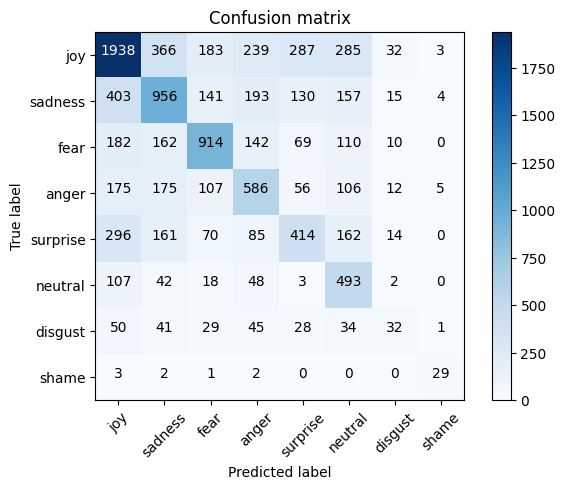

In [70]:
plot_confusion_matrix(cm,class_names)

In [71]:
# import warnings
# warnings.filterwarnings('ignore')

In [72]:
# Classication Report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.58      0.60      3333
         1.0       0.50      0.48      0.49      1999
         2.0       0.62      0.58      0.60      1589
         3.0       0.44      0.48      0.46      1222
         4.0       0.42      0.34      0.38      1202
         5.0       0.37      0.69      0.48       713
         6.0       0.27      0.12      0.17       260
         7.0       0.69      0.78      0.73        37

    accuracy                           0.52     10355
   macro avg       0.49      0.51      0.49     10355
weighted avg       0.53      0.52      0.52     10355



In [73]:
# Classication Report
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

         joy       0.61      0.58      0.60      3333
     sadness       0.50      0.48      0.49      1999
        fear       0.62      0.58      0.60      1589
       anger       0.44      0.48      0.46      1222
    surprise       0.42      0.34      0.38      1202
     neutral       0.37      0.69      0.48       713
     disgust       0.27      0.12      0.17       260
       shame       0.69      0.78      0.73        37

    accuracy                           0.52     10355
   macro avg       0.49      0.51      0.49     10355
weighted avg       0.53      0.52      0.52     10355

